In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import typing
from typing import Type

import numpy as np
import torch

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
import devinterp.utils as utils

import re
import yaml
from dataclasses import dataclass


from dgp import get_dataloader
from model import GPT

import torch.nn.functional as F
from utils import move_to_device

import pickle
import os

from utils.loading import Conf
from utils.llc import calculate_llc_for_file, evaluate_fn

from functools import partial

In [4]:
hf_repo_name = "ConceptPerlocation_px47qrx5_ckpts"
model_dir = f'results/scratch/{hf_repo_name}'

In [5]:
config = Conf.load_from_yaml("config/conf.yaml")
config.device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=config.data.num_iters * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
)

pad_token_id = dataloader.dataset.pad_token_id

evaluator = partial(evaluate_fn, pad_token_id=pad_token_id, config=config)

In [6]:
num_chains = 5
num_draws = 150
iteration = 1000
gammas = [50, 100.0, 200.0, 400.0, 800.0]
eps = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
llcs = {}
# grid sweep
for e in eps:
    for g in gammas:
        print(f"e: {e}, g: {g}")
        llc = calculate_llc_for_file(
            iteration=iteration,
            dataloader=dataloader,
            model_dir=model_dir,
            config=config,
            evaluate_fn=evaluator,
            optimizer_kwargs=dict(lr=e, localization=g, nbeta=30),
            num_chains=num_chains,
            num_draws=num_draws,
        )
        llcs[(e, g)] = llc

Chain 4: 100%|██████████| 150/150 [00:15<00:00,  9.75it/s]


e: 0.01, g: 800.0


Chain 4: 100%|██████████| 150/150 [00:15<00:00,  9.88it/s]


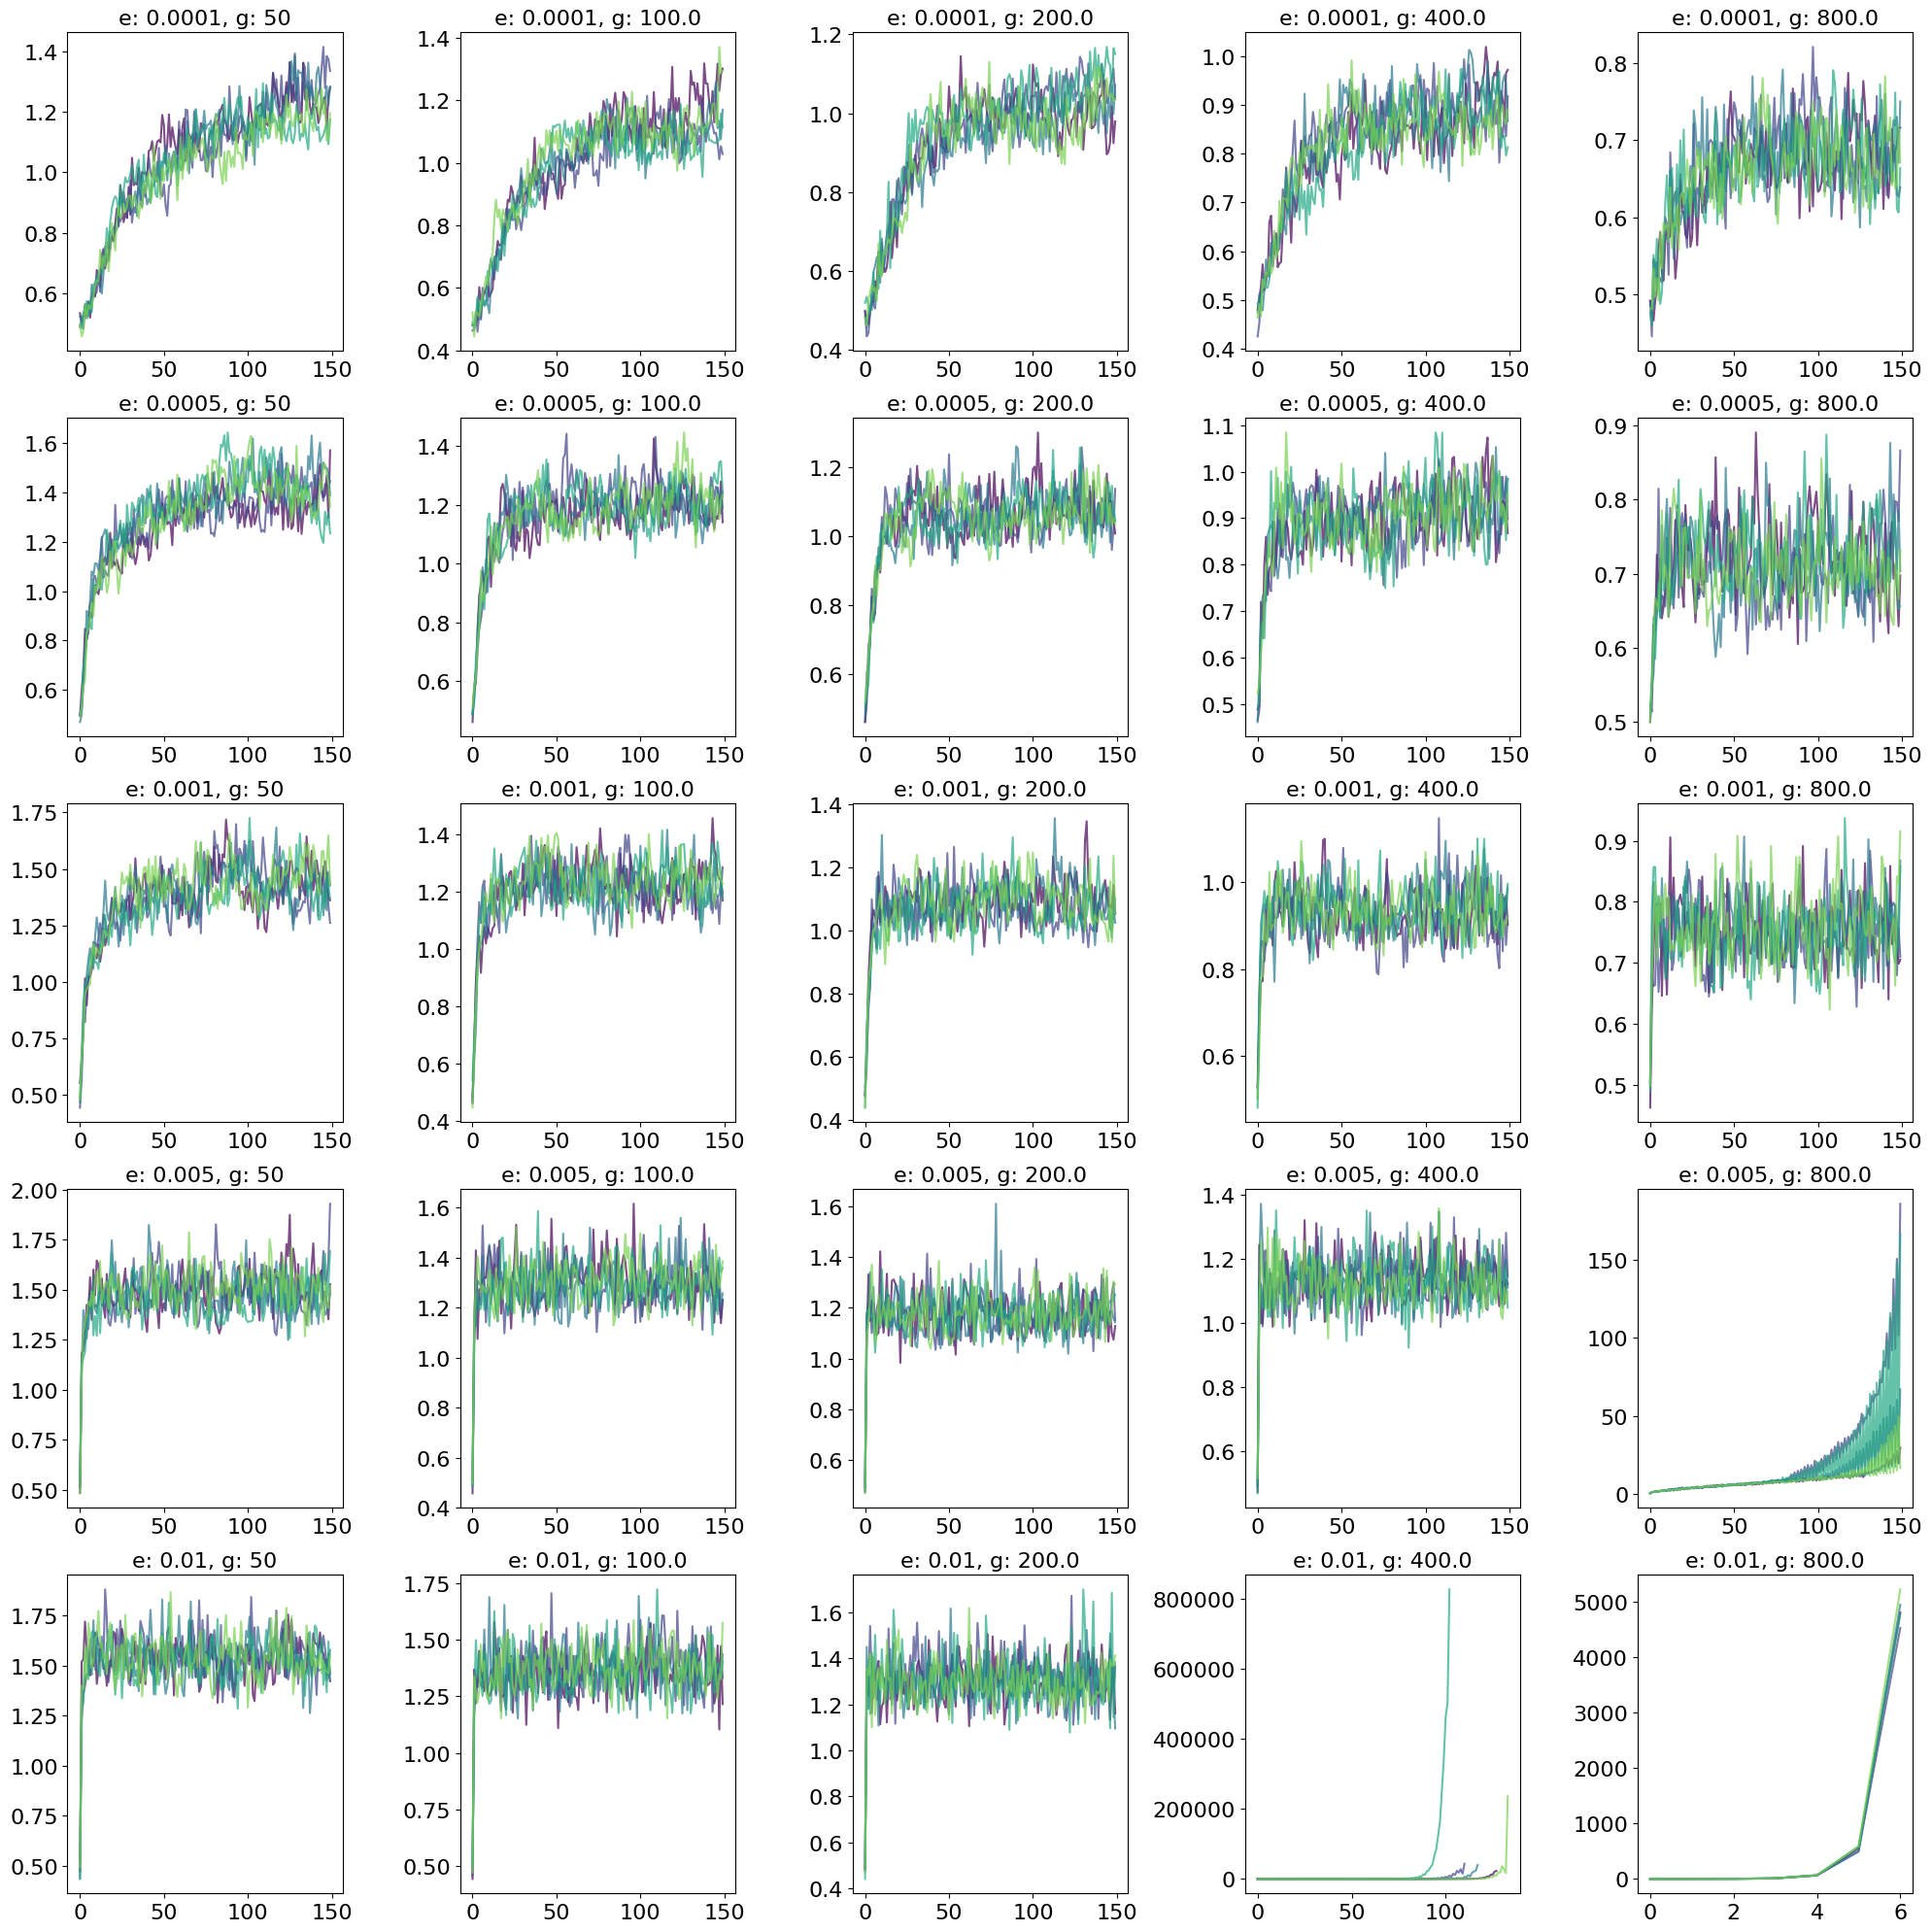

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(eps), len(gammas), figsize=(20, 20))
for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        llc_output = llcs[(e, g)]
        traces = llc_output["loss/trace"]
        # set colormap
        cmap = plt.get_cmap("viridis")
        for color, chain in enumerate(traces):
            ax[i, j].plot(chain, alpha=0.7, color=cmap(color  / len(traces)))
        ax[i, j].set_title(f"e: {e}, g: {g}")

# set fontsize
for a in ax.flatten():
    a.tick_params(axis="both", which="major", labelsize=16)
    a.set_title(a.get_title(), fontsize=16)
plt.tight_layout()

In [22]:
llcs[(0.0005, 100.0)].keys()

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

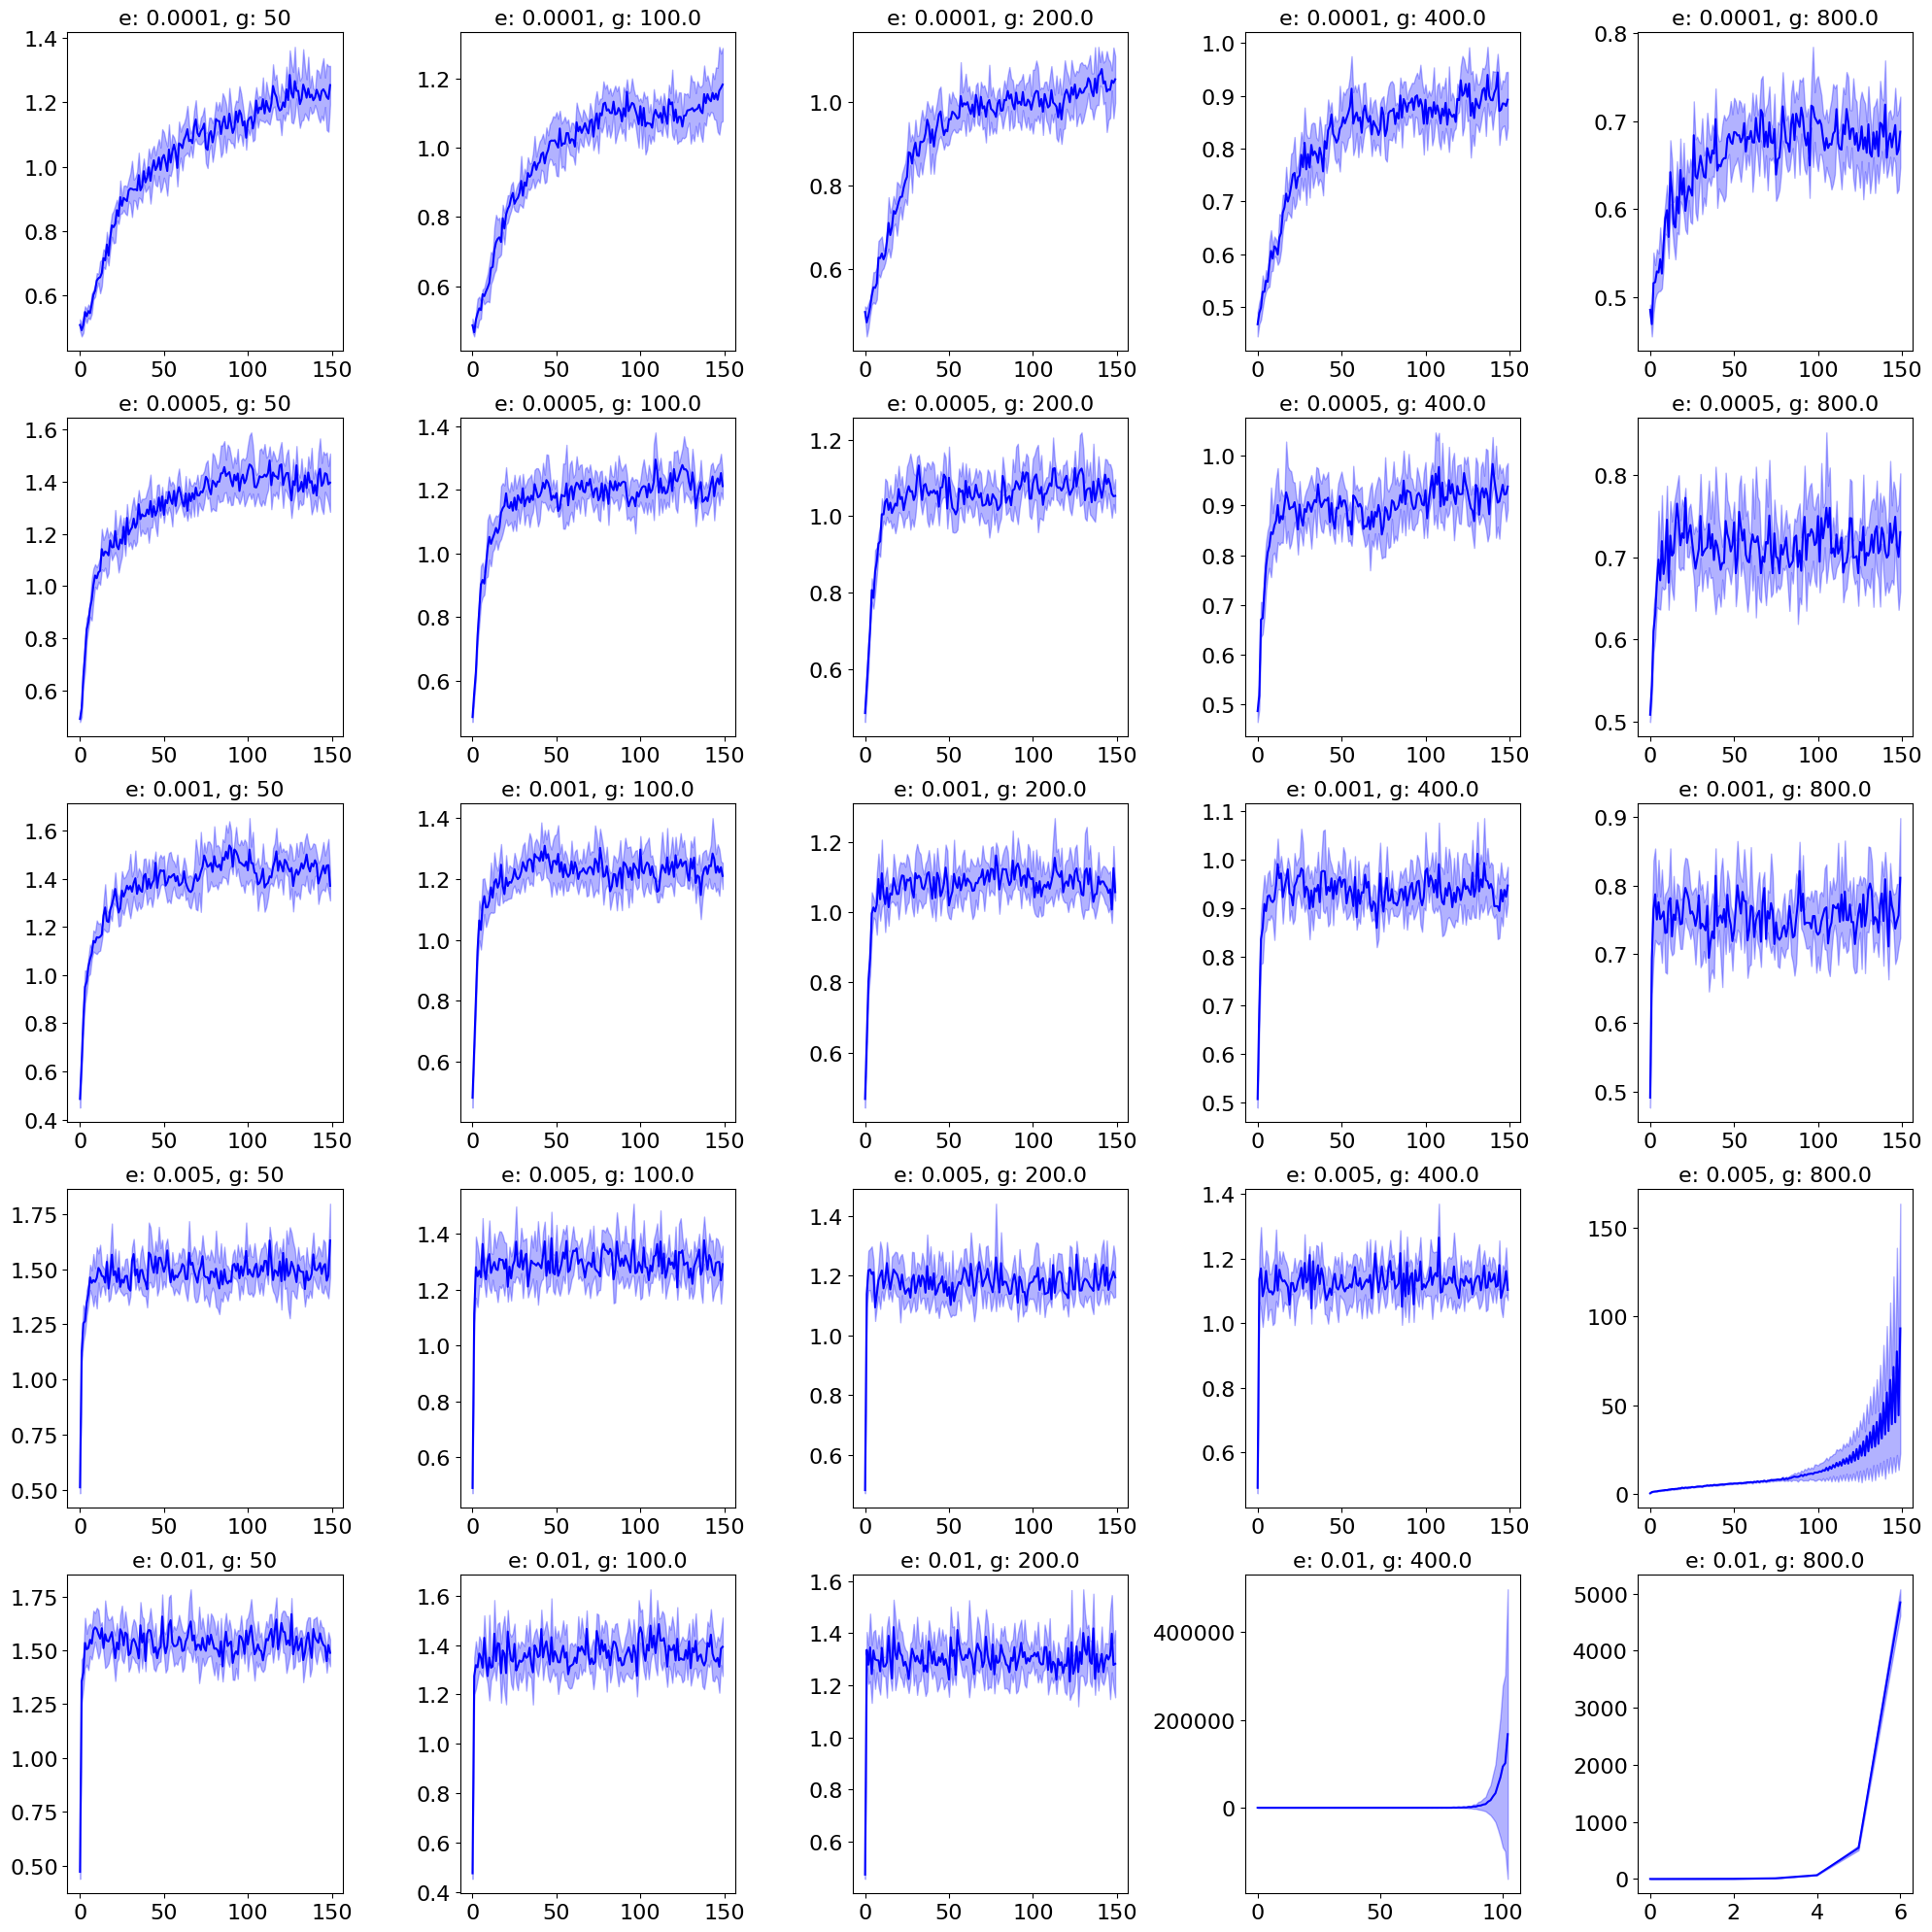

In [16]:
std = {}
mean = {}
for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        llc_output = llcs[(e, g)]
        traces = llc_output["loss/trace"]
        trace_std = np.std(traces, axis=0)
        trace_mean = np.mean(traces, axis=0)
        std[(e, g)] = trace_std
        mean[(e, g)] = trace_mean

fig, ax = plt.subplots(len(eps), len(gammas), figsize=(20, 20))

for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        ax[i, j].plot(mean[(e, g)], color="blue")
        ax[i, j].fill_between(
            np.arange(len(mean[(e, g)])),
            mean[(e, g)] - std[(e, g)],
            mean[(e, g)] + std[(e, g)],
            color="blue",
            alpha=0.3,
        )
        ax[i, j].set_title(f"e: {e}, g: {g}")


# set fontsize
for a in ax.flatten():
    a.tick_params(axis="both", which="major", labelsize=16)
    a.set_title(a.get_title(), fontsize=16)
plt.tight_layout()

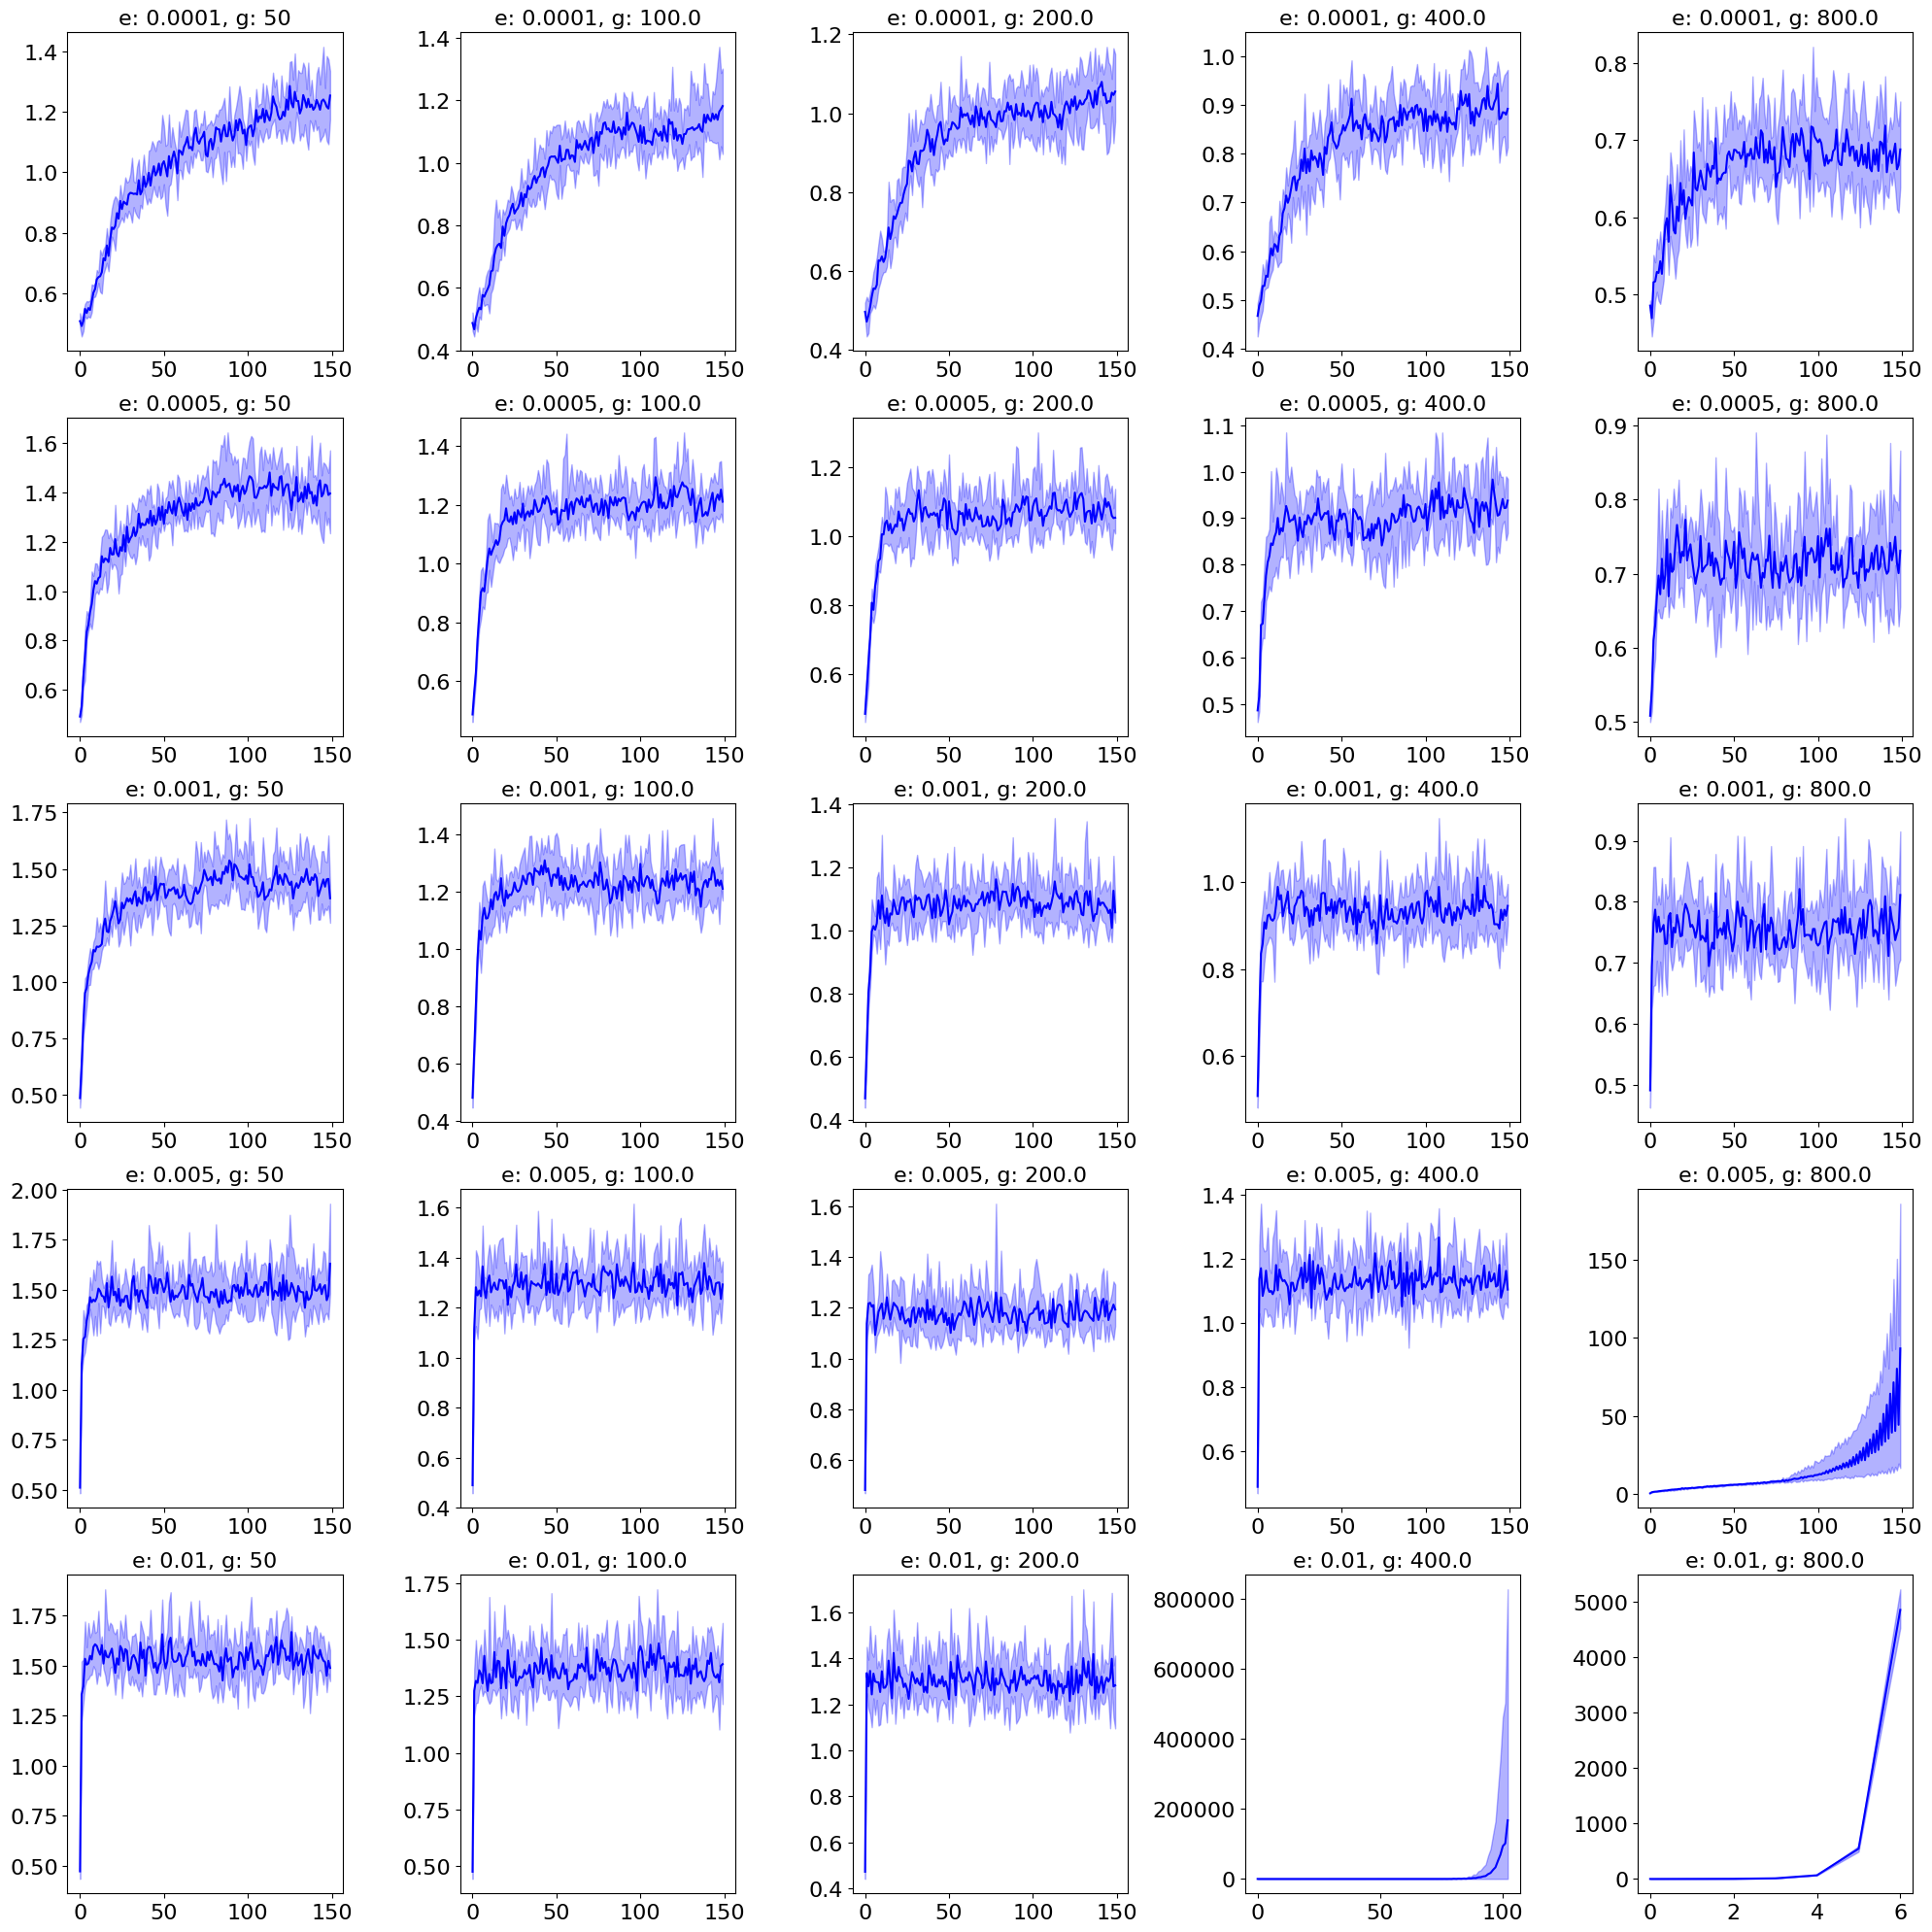

In [17]:
mins = {}
maxs = {}
for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        llc_output = llcs[(e, g)]
        traces = llc_output["loss/trace"]
        trace_min = np.min(traces, axis=0)
        trace_max = np.max(traces, axis=0)
        mins[(e, g)] = trace_min
        maxs[(e, g)] = trace_max

fig, ax = plt.subplots(len(eps), len(gammas), figsize=(20, 20))

for i, e in enumerate(eps):
    for j, g in enumerate(gammas):
        ax[i, j].plot(mean[(e, g)], color="blue")
        ax[i, j].fill_between(
            np.arange(len(mean[(e, g)])),
            mins[(e, g)],
            maxs[(e, g)],
            color="blue",
            alpha=0.3,
        )
        ax[i, j].set_title(f"e: {e}, g: {g}")


# set fontsize
for a in ax.flatten():
    a.tick_params(axis="both", which="major", labelsize=16)
    a.set_title(a.get_title(), fontsize=16)
plt.tight_layout()

In [19]:
import pickle
dump_dir = "./results/scratch/ConceptPerlocation_px47qrx5_ckpts/llc/"
with open(f"{dump_dir}/icl1_sweep.pkl", "wb") as f:
    pickle.dump(llcs, f)